In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid

from src.torch_geo_models import GraphSAGE, LinkPredictor
from src.data.gamma.positional_arxiv import load_dataset, get_train_val_test_edges_auc,\
    get_val_test_edges_link_pred, prepare_adjencency, get_edge_index_from_adjencency
from src.train.positional_omega.node2vec import PositionalOmegaNode2Vec

In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/07-1-positional_omega_node2vec_cossim.log'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

data, edges_train_auc, edges_val_auc, edges_test_auc =\
    get_train_val_test_edges_auc(dataset, device=device)

data, edges_val, edges_test, neg_edges_val, neg_edges_test, neg_edges_train =\
    get_val_test_edges_link_pred(data, remove_from_data=True, device=device, get_neg_edges_train=True)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

## Training

In [7]:
pq_space = np.logspace(-1, 1, 5).round(2)
pq_space

array([ 0.1 ,  0.32,  1.  ,  3.16, 10.  ])

In [8]:
omega = PositionalOmegaNode2Vec(
                device,
                edge_index,
                data.num_nodes,
                1,
                1,
                run=0)

In [9]:
for run in range(5):
    for p in pq_space:
        for q in pq_space:
            omega = PositionalOmegaNode2Vec(
                device,
                edge_index,
                data.num_nodes,
                p,
                q,
                run=run)
            torch.cuda.empty_cache()
            omega.train(edge_index,
                        edges_val,
                        edges_test,
                        neg_edges_train,
                        neg_edges_val,
                        neg_edges_test,
                        edges_train_auc,
                        edges_val_auc,
                        edges_test_auc,
                        data.y)
            omega.discard_run_not_optimal_models()

KeyboardInterrupt: 

## Results

### For a layer number

In [15]:
pq_space = np.logspace(-1, 1, 5).round(2)
param_grid = ParameterGrid({
    'p': pq_space,
    'q': pq_space,
})

In [18]:
param_grid[0]

{'q': 0.1, 'p': 0.1}

In [19]:
metrics = PositionalOmegaNode2Vec.read_metrics(**param_grid[0])
print(metrics.shape)
metrics.head()

(205, 11)


,p,q,run,epoch,node2vec_loss,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0.1,0.1,0,0,None,1.391305,1.390868,1.390615,0.499268,0.497669,0.499118
1,0.1,0.1,0,0,None,1.391509,1.391338,1.390519,0.499268,0.497669,0.499118
2,0.1,0.1,0,10,1.8505686521530151,1.303377,1.320158,1.319289,0.528592,0.515522,0.512574
3,0.1,0.1,0,20,1.1011130809783936,1.219224,1.239520,1.239899,0.540303,0.517995,0.514518
4,0.1,0.1,0,30,0.9480607509613037,1.167496,1.190745,1.190060,0.540112,0.534569,0.533392


### Sumarize metrics per epoch

In [20]:
metrics_cols = metrics.columns[3:]
metrics_cols

Index(['epoch', 'node2vec_loss', 'loss_train', 'loss_val', 'loss_test',
       'auc_train', 'auc_val', 'auc_test'],
      dtype='object')

In [21]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [22]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

/tmp/ipykernel_9166/1408155837.py:5: FutureWarning:

['node2vec_loss'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



,epoch_mean,epoch_std,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,,,
0,0.0,0.0,1.391447,0.000766,1.391551,0.001071,1.390778,0.000722,0.499991,0.000979,0.499713,0.001992,0.499703,0.000831
10,10.0,0.0,1.303491,0.000963,1.320021,0.000860,1.319403,0.000780,0.528413,0.000581,0.518017,0.003120,0.514098,0.002916
20,20.0,0.0,1.219047,0.000883,1.239175,0.001102,1.239491,0.000817,0.539963,0.000832,0.520568,0.002259,0.515958,0.001399
30,30.0,0.0,1.167568,0.000733,1.190551,0.000905,1.190017,0.000182,0.541172,0.001198,0.537912,0.002723,0.535325,0.001849
40,40.0,0.0,1.132044,0.000581,1.156562,0.000688,1.155642,0.000225,0.559080,0.001692,0.567060,0.001702,0.566420,0.001294


In [23]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,epoch_mean,epoch_std,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,,,
90,90.0,0.0,1.089950,0.000617,1.115303,0.000283,1.114129,0.000517,0.609766,0.000794,0.622975,0.000582,0.621591,0.001126
80,80.0,0.0,1.090280,0.000590,1.115457,0.000954,1.114458,0.000535,0.608050,0.000694,0.622562,0.000419,0.621187,0.000952
100,100.0,0.0,1.090865,0.000631,1.116430,0.000477,1.115340,0.000733,0.609808,0.000688,0.622064,0.001254,0.620351,0.000702
110,110.0,0.0,1.092261,0.000754,1.117814,0.000630,1.116916,0.000714,0.608916,0.000531,0.620712,0.000686,0.618761,0.000519
120,120.0,0.0,1.094247,0.000510,1.119412,0.000755,1.118642,0.000704,0.608247,0.000891,0.619578,0.000540,0.617295,0.000265


/tmp/ipykernel_9166/483931691.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_9166/483931691.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_9166/483931691.py:35: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use

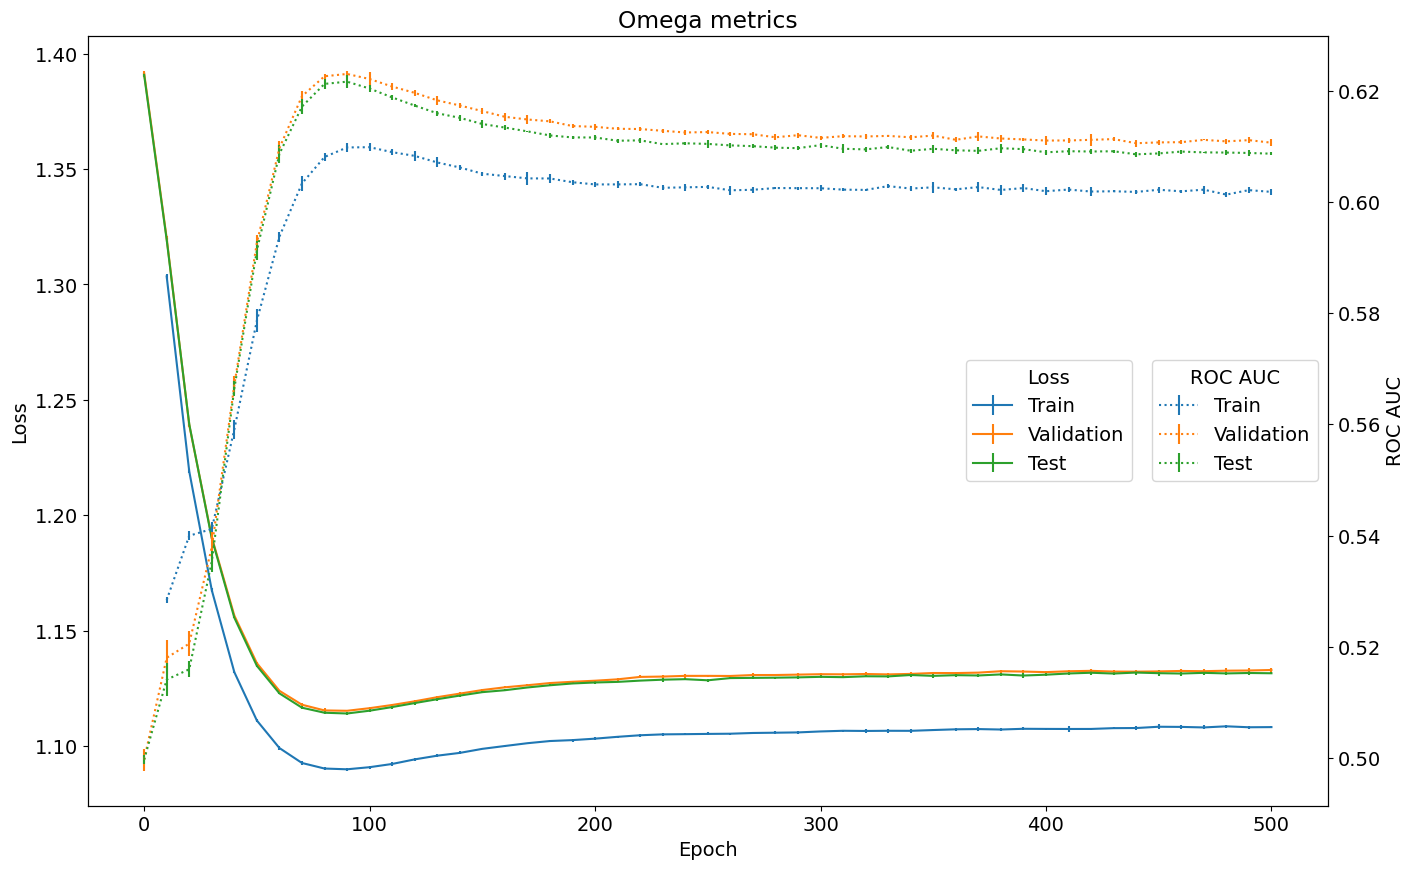

In [24]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Omega metrics')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig('reports/images/positional_omega_node2vec_cossim_training_metrics.pdf')

### Comparing Validation Performance for All Layer numbers

In [26]:
n_layers_list = range(1, 4)

In [27]:
tuple(param_grid[0].items())

(('q', 0.1), ('p', 0.1))

In [31]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}

full_metrics_list = []
for params in param_grid:
    param_tuple = tuple(params.items())
    metrics = PositionalOmegaNode2Vec.read_metrics(**params)
    full_metrics_list.append(metrics)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    max_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[param_tuple] = auc_val
    mean_loss_val_dict[param_tuple] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[param_tuple] = auc_val
    std_loss_val_dict[param_tuple] = loss_val

full_metrics_df = pd.concat(full_metrics_list)

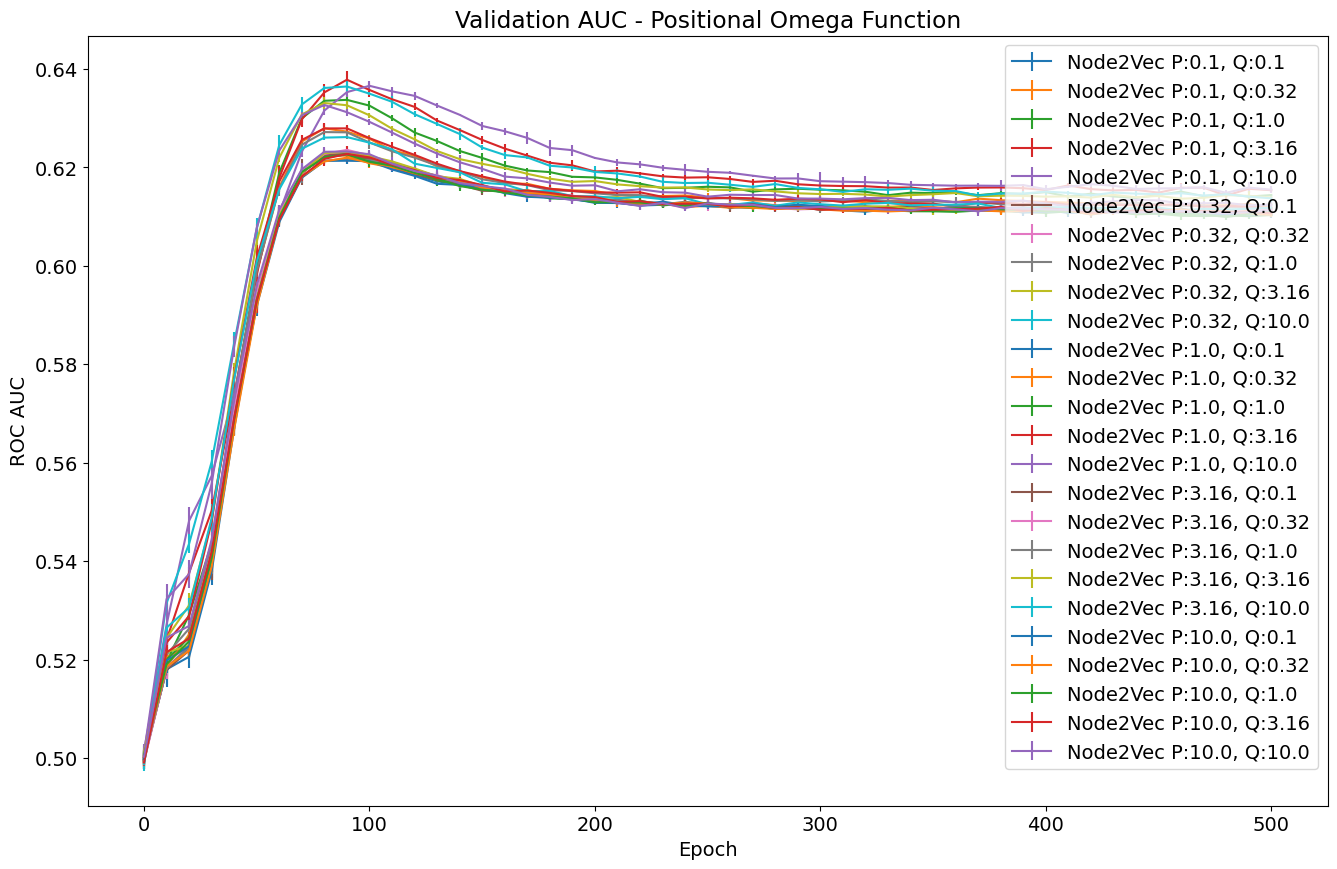

In [32]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Positional Omega Function')

for params in param_grid:
    param_tuple = tuple(params.items())
    ax1.errorbar(
        mean_auc_val_dict[param_tuple].index,
        mean_auc_val_dict[param_tuple],
        yerr=std_auc_val_dict[param_tuple],
        ls='-',
        label=f'Node2Vec P:{params["p"]}, Q:{params["q"]}')


# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

### Best AUC Heatmap

<AxesSubplot: xlabel='q', ylabel='p'>

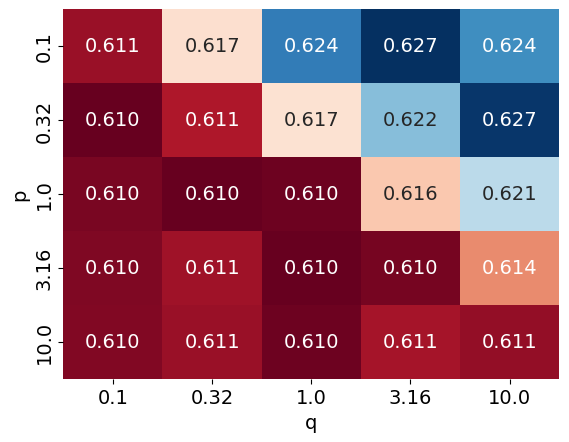

In [52]:
sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_train'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f')

<AxesSubplot: xlabel='q', ylabel='p'>

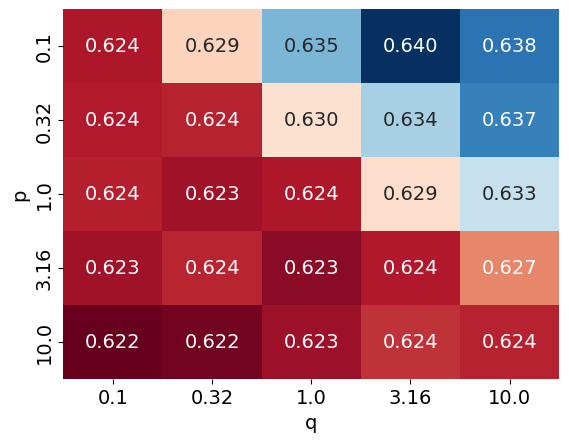

In [53]:
sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_val'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f')

<AxesSubplot: xlabel='q', ylabel='p'>

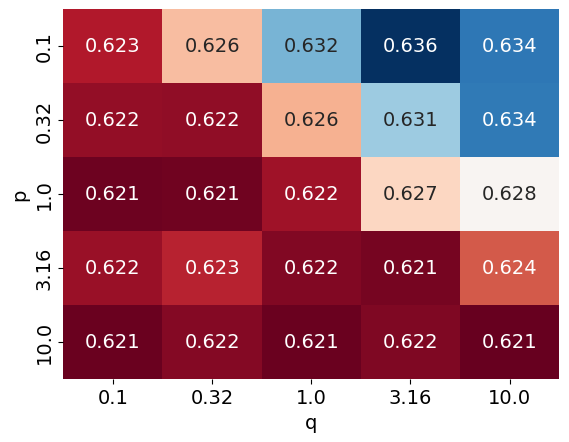

In [54]:
sns.heatmap(
    full_metrics_df.groupby(['p', 'q'])['auc_test'].max().unstack('q'),
    cmap='RdBu',
    annot=True,
    cbar=False,
    fmt='.3f')

## Score Best model

In [56]:
best_model_metrics = full_metrics_df.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

p                               0.1
q                              3.16
run                               2
epoch                            90
node2vec_loss    0.8047587275505066
loss_train                 1.092583
loss_val                   1.126565
loss_test                   1.12575
auc_train                  0.622313
auc_val                    0.640109
auc_test                   0.635919
Name: 111, dtype: object

In [58]:
best_model_metrics.to_json('models/positional_omega_node2vec/best_model_info.json')